In [1]:
using GPFlux
using Flux
using Zygote
using PyPlot
using Random
using DelimitedFiles
using LinearAlgebra
using Test

Random.seed!(4);

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/hongbinren/.julia/packages/CUDAdrv/mCr0O/src/CUDAdrv.jl:69


In [2]:
# read CO2 data
data = readdlm("CO2_data.csv", ',')
year = data[:,1]; co2 = data[:,2];
# Split the data into training and testing data
xtrain = year[year.<2004]; ytrain = co2[year.<2004];
xtest = year[year.>=2004]; ytest = co2[year.>=2004];
Xtrain = reshape(xtrain, 1, length(xtrain));
Xtest = reshape(xtest, 1, length(xtest));

In [12]:
# use a composite kernel 
se1_kernel = IsoGaussKernel([4.0], [4.0])
per_kernel = IsoPeriodKernel([0.0], [0.0], [1.0])
se2_kernel = IsoGaussKernel([4.0], [0.0])
rq_kernel = IsoRQKernel([0.0], [-1.0], [0.0])
se3_kernel = IsoGaussKernel([-2.0], [-2.0])

se_per_kernel = SE_mul_PeriodKernel((se2_kernel, per_kernel))

kernel = AddCompositeKernel((se1_kernel, se_per_kernel, rq_kernel, se3_kernel))

# check PSD
@show isposdef(se_per_kernel(Xtrain))
@show isposdef(kernel(Xtrain))

isposdef(se_per_kernel(Xtrain)) = true
isposdef(kernel(Xtrain)) = true


true

In [13]:
# fit gp 
zero_mean = ConstantMean()
lnoise = [-2.0]
gp = GaussProcess(zero_mean, kernel, lnoise)
ps = params(gp)
negloglik(gp, Xtrain, ytrain)
gs = gradient(()->negloglik(gp, Xtrain, ytrain), ps)
gs.grads

IdDict{Any,Any} with 14 entries:
  [1.0]  => [17.5788]
  [-2.0] => [-346.022]
  [0.0]  => [-0.19]
  [0.0]  => [17.6995]
  [0.0]  => [419.728]
  [0.0]  => [-17.0545]
  [4.0]  => [-12.7205]
  [4.0]  => [-67.4077]
  [4.0]  => [0.920669]
  [-2.0] => [85.1632]
  [0.0]  => [-38.8524]
  [-2.0] => [-63.8567]
  [-1.0] => [3.7943]
  [0.0]  => [25.7066]

In [14]:
ps

Params([[0.0], [4.0], [4.0], [4.0], [0.0], [0.0], [0.0], [1.0], [0.0], [-1.0], [0.0], [-2.0], [-2.0], [-2.0]])

In [15]:
function calc_g!(G, θ)
    dispatch!(gp, θ)
    ps = params(gp)
    gs = gradient(()->negloglik(gp, Xtrain, ytrain), ps)

    j = 1
    for p in ps
        G[j] = gs.grads[p][1]
        j += 1
    end
    G
end

function loss(θ)
    dispatch!(gp, θ)
    negloglik(gp, Xtrain, ytrain)
end


θ = flatten_params(ps)
@show loss(θ)
@show calc_g!(zero(θ), θ)
@test loss(θ) ≈ negloglik(gp, Xtrain, ytrain)

loss(θ) = 228.43958901752296
calc_g!(zero(θ), θ) = [-0.18999983389168662, 0.9206692328560756, -67.40770897133937, -12.720521085503274, 17.699520174958707, 419.7283968214397, -38.852435311460795, 17.578817112330526, -17.05449002236014, 3.7942954689793, 25.706593692095794, 85.16318380072761, -63.85667425929943, -346.02195928758186]


Test Passed

In [16]:
using Optim

θ₀ = copy(θ)
optimize(loss, calc_g!, θ₀, LBFGS(), Optim.Options(f_tol=1e-5,))

 * Status: success

 * Candidate solution
    Minimizer: [6.31e-03, 4.57e+00, 5.93e+00,  ...]
    Minimum:   1.157549e+02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 4.00e+00, 4.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 3.66e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.17e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.29e-05 ≰ 1.0e-05
    |f(x) - f(x')|/|f(x')| = 5.43e-07 ≰ 0.0e+00
    |g(x)|                 = 1.46e+01 ≰ 1.0e-08

 * Work counters
    Seconds run:   114  (vs limit Inf)
    Iterations:    27
    f(x) calls:    108
    ∇f(x) calls:   108


In [17]:
ps = params(gp)

Params([[0.006312176254132247], [4.568896522084496], [5.925541556790953], [4.531410967519122], [-0.09644074918812583], [-0.0004061805296766155], [0.3429162073234375], [0.9037688469565999], [0.29808239160969885], [-1.0120634062594323], [-0.16523874197958133], [-2.1241286483199535], [-1.7811484307953889], [-1.6571341588625172]])

In [18]:
Year = reshape(year, 1, :)
pred_y, pred_σ2 = predict(gp, Year, Xtrain, ytrain);

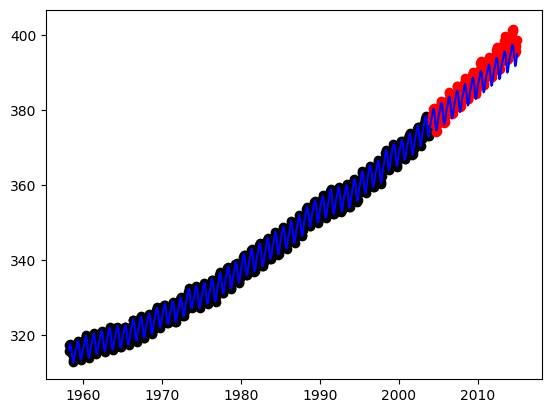

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x155a4fcc0>

In [19]:
scatter(xtrain, ytrain, color="k")
scatter(xtest, ytest, color="r")
plot(year, pred_y, "b")

In [ ]:
# minimize negative loglik

using Flux.Optimise: update!

optimizer = ADAM(0.001)
loss = []
for i in 1:900
    ll = negloglik(gp, Xtrain, ytrain)
    push!(loss, ll)
    if i==1 || i%100 == 0
        @info "step=$i, loss=$ll"
    end
    gs = gradient(()->negloglik(gp, Xtrain, ytrain), ps)
    for p in ps
        update!(optimizer, p, gs[p])
    end
end

plot(loss)
xscale("log")